In [ ]:
#======================= import essential libraries ===========================
import math
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from lib.python_vtu import vtu_extract_element_connectivity,vtu_extract_fields
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib.patches as patches
from scipy.signal import find_peaks
from scipy.integrate import simps 

#======================= input parameters  ===========================
Hght = 500                   # Height(m)
Lngth = 2e4                  # Lngth(m)               
tol = 1e-3                   # Tolerance(m)
T = 0.5*3.154e7/(12.0*30.0)  # solar tide period
sea_level = Hght*0.917       # sea level(m)
r_lake = 0.5e3               # range of lake (m)
KIc = 1e5                # Ice fracture toughness
rho_w = 1e3              # water density (kg/m^3)
rho_i = 917              # ice density (kg/m^3)
g = 9.8 # m/s^2          # gravity (m/s^2)
pi = math.pi             # pi
basin_elev = 80.0        # basin_elevation (m)
depth_basin = 90.0 - basin_elev  # basin depth (m)

fs = 14                  # FontSize
marker = 6               # MarkerType
ny = 1e4                 # y grid resolution

# plot setting
x_left = 2
x_right = 18
d_l = 15                 # basin depth
d_f = 125                # fracture length
h_w = 10                 # lake deth

nt_per_year =  50*1000                # Number of timesteps per year. (tidal simulation)
t_final =  10.0/360.*3.154e7          # Final time (yr*sec_per_year). (tidal simulation)
nt = int(nt_per_year*t_final/3.154e7) # Number of time steps
dt = t_final/nt                       # Timestep size
nt = 800                              # number of frames for plot
#======================= functions  ===========================
# ocean tide
def interface(x):
    return 0.5*(np.abs(200-0.02*x)+(200-0.02*x))
def bedrock(x):
    return (200-0.02*x)

# semi-diurnal tide
def semi_diurnal_tide(t):
    SLC = np.sin(2*np.pi*t/(12*3600))  # tidal frequency of 2 per day
    return SLC
# semi-diurnal tide with solar modulation
def neap_spring_tide(t):
    return 1.0/2.498*np.sin(2.0*np.pi*t/(0.5*3.154e7/12.0/30.0))\
            +1.5/2.498*1.0*np.sin(2.0*np.pi*t*12.42/12/(0.5*3.154e7/12.0/30.0))
# hydrostatic water pressure
def pressure_water(depth):
    return 0.5*(rho_w*g*depth+abs(rho_w*g*depth))
# cryostatic pressure
def pressure_ice(depth):
    return rho_i*g*depth

#======================= weight functions  ===========================
# weight function used to calculate K1
def f1(gamma):
    return 0.3*(1-gamma**(5/4))
def f2(lam):
    return 0.5*(1-np.sin(0.5*pi*lam))*(2+np.sin(0.5*pi*lam))
def phi(lam,gamma):
    return np.sqrt(np.tan(0.5*pi*lam) / (1.0-(np.cos(0.5*pi*lam)/np.cos(0.5*pi*gamma*lam))**2))
def greens1(lam,gamma):
    return 2.0/np.sqrt(2*Hght)*(1+f1(gamma)*f2(lam))*phi(lam,gamma)

# weight function used to calculate K2 this is NOT CORRECT
def greens2(lam,gamma):
    return 2.0/np.sqrt(2)*(1+0.297*np.sqrt(1.0-gamma**2)*(1-np.cos(0.5*pi*lam)))*phi(lam,gamma)*np.sin(0.5*pi*lam*gamma)/np.sin(0.5*pi*lam)

#======================= stress intensity factor  ===========================
critical_lake_depth = []
file = '../results/stokes_tidal_response_U09ma_L20000_Slope0_02_A3e_24_n3_0_mu0_30e9_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12'

t = np.arange(0,nt*dt,dt)
#------------------------ read the data ------------------------
X = np.loadtxt(file+ "/line_plot_data/X.txt", dtype='f', delimiter=' ')
Gamma_h = np.loadtxt(file+"/line_plot_data/Gamma_h.txt", dtype='f', delimiter=' ', usecols=range(nt))
Gamma_s = np.loadtxt(file+ "/line_plot_data/Gamma_s.txt", dtype='f', delimiter=' ', usecols=range(nt))
max_tension_t = np.loadtxt(file +'/max_tension_t.txt', dtype='f', delimiter=',')
max_tension = np.loadtxt(file +'/max_tension_net.txt', dtype='f', delimiter=',')   
max_tension_x = np.loadtxt(file +'/max_tension_x.txt', dtype='f', delimiter=',')   
peaks, _ = find_peaks(max_tension, height=(0, 2e5))     # find the maximum tidal stress
troughs, _ = find_peaks(-max_tension, height=(0, 2e5))  # find the minimum tidal stress

#------------------------ Get the max tidal stress ------------------------
if peaks.size!=0:
    n_frame = peaks[-1]
else:
    n_frame = 700
n_frame_max = n_frame
print('At time '+str(t[n_frame]/T) + ', the max stress is '+ str(max_tension[n_frame]/1e3) +' kPa')

xindex_max = np.argmin(abs(X-max_tension_x[n_frame]))
thickness_max = Gamma_h[xindex_max,n_frame]-Gamma_s[xindex_max,n_frame]-depth_basin
delta_h_max = thickness_max/ny
yi_max = np.arange(Gamma_h[xindex_max,n_frame]-depth_basin-delta_h_max, Gamma_s[xindex_max,n_frame]+delta_h_max,-delta_h_max)
xi_max = X[xindex_max]*np.ones_like(yi_max)

n_frame_str="{:0>6d}".format(n_frame)
filename = file+"/field_plot_data"
# Read in deviatoric stress
e2v = vtu_extract_element_connectivity(filename+"/sigma"+n_frame_str+".vtu")
pf, cf, coor = vtu_extract_fields(filename+"/sigma"+n_frame_str+".vtu")
pf_names = list(pf.keys())
cf_names = list(cf.keys())
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v) # triangulation
interp_cubic_geom = mtri.CubicTriInterpolator(tri, pf[pf_names[0]][:,0], kind='geom')
sigma_xx_deviatoric_max = interp_cubic_geom(xi_max, yi_max)

# Read in pressure
e2v = vtu_extract_element_connectivity(filename+"/p"+n_frame_str+".vtu")
pf, cf, coor = vtu_extract_fields(filename+"/p"+n_frame_str+".vtu")
pf_names = list(pf.keys())
cf_names = list(cf.keys())
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v) # triangulation
interp_cubic_geom = mtri.CubicTriInterpolator(tri, pf[pf_names[0]], kind='geom')
p_i_max = interp_cubic_geom(xi_max, yi_max)

#------------------------ Get the min tidal stress ------------------------
if troughs.size!=0:
    n_frame = troughs[-1]
else:
    n_frame = 1e3
n_frame_min = n_frame
print('At time '+str(t[n_frame]/T) + ', the min stress is '+ str(max_tension[n_frame]/1e3) +' kPa')

xindex_min = np.argmin(abs(X-max_tension_x[n_frame]))
thickness_min = Gamma_h[xindex_min,n_frame]-Gamma_s[xindex_min,n_frame]
delta_h_min = thickness_min/ny
yi_min = np.arange(Gamma_h[xindex_min,n_frame]-depth_basin-delta_h_min, Gamma_s[xindex_min,n_frame]+delta_h_min,-delta_h_min)
xi_min = X[xindex_min]*np.ones_like(yi_min)

n_frame_str="{:0>6d}".format(n_frame)
# Read in stress 
e2v = vtu_extract_element_connectivity(filename+"/sigma"+n_frame_str+".vtu")
pf, cf, coor = vtu_extract_fields(filename+"/sigma"+n_frame_str+".vtu")
pf_names = list(pf.keys())
cf_names = list(cf.keys())
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v) # triangulation
interp_cubic_geom = mtri.CubicTriInterpolator(tri, pf[pf_names[0]][:,0], kind='geom')
sigma_xx_deviatoric_min = interp_cubic_geom(xi_min, yi_min)

# Read in pressure 
e2v = vtu_extract_element_connectivity(filename+"/p"+n_frame_str+".vtu")
pf, cf, coor = vtu_extract_fields(filename+"/p"+n_frame_str+".vtu")
pf_names = list(pf.keys())
cf_names = list(cf.keys())
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v) # triangulation
interp_cubic_geom = mtri.CubicTriInterpolator(tri, pf[pf_names[0]], kind='geom')
p_i_min = interp_cubic_geom(xi_min, yi_min)

# ------------------------ integrate along the depth ------------------------
v_dl = np.arange(0,depth_basin+1e-3,0.5) # lake depth seires
n_dl = np.shape(v_dl)[0]

vlambda_max = Gamma_h[xindex_max,n_frame_max] - depth_basin - yi_max # corresponding crack length dd 
vlambda_min = Gamma_h[xindex_min,n_frame_min] - depth_basin - yi_min # corresponding crack length dd 

# crack length series
vZc_max = np.concatenate((vlambda_max[9:100:10],vlambda_max[200::100]))
n_Zc_max = np.shape(vZc_max)[0]
vZc_min = np.concatenate((vlambda_min[9:100:10],vlambda_min[200::100]))
n_Zc_min = np.shape(vZc_min)[0]

# stress intensity factor
vK1_max = np.zeros([n_dl,n_Zc_max])
vK1_min = np.zeros([n_dl,n_Zc_min])

for k,depth_lake in enumerate(v_dl):
    # water pressure in Pascal
    h_w_max = Gamma_h[xindex_max,n_frame_max] - depth_basin + depth_lake
    p_w_max = pressure_water(h_w_max - yi_max)
    
    h_w_min = Gamma_h[xindex_min,n_frame_min] - depth_basin + depth_lake
    p_w_min = pressure_water(h_w_min - yi_min)

    # total contribution to fracturing
    sigma_xx_max = sigma_xx_deviatoric_max - p_i_max + p_w_max
    sigma_xx_min = sigma_xx_deviatoric_min - p_i_min + p_w_min
    
    # calculate K1_max
    for j,Z_c in enumerate(vZc_max):     
        dK1_max = np.zeros(np.shape(vlambda_max))
        up_bound_index = np.where(abs(vlambda_max-Z_c)<tol)[0][0]                       
        for il,dist in enumerate(vlambda_max[:up_bound_index]):
            dK1_max[il] = sigma_xx_max[il]*greens1(Z_c/thickness_max,dist/Z_c)

        vK1_max[k,j] = simps(dK1_max[:up_bound_index],vlambda_max[:up_bound_index])
            
     # calculate K1_min
    for j,Z_c in enumerate(vZc_min):     
        dK1_min = np.zeros(np.shape(vlambda_min))
        up_bound_index = np.where(abs(vlambda_min-Z_c)<tol)[0][0]                       
        for il,dist in enumerate(vlambda_min[:up_bound_index]):       
            dK1_min[il] = sigma_xx_min[il]*greens1(Z_c/thickness_min,dist/Z_c)

        vK1_min[k,j] = simps(dK1_min[:up_bound_index],vlambda_min[:up_bound_index])

# save the stress intensity factor K1 versus crack length
np.savetxt("./" + file +'/K1_max.txt', vK1_max, delimiter=',')   # K1
np.savetxt("./" + file +'/K1_min.txt', vK1_min, delimiter=',')   # K1
np.savetxt("./" + file +'/lake_depth.txt', v_dl, delimiter=',')   # lake depth series
np.savetxt("./" + file +'/crack_length_max.txt', vZc_max, delimiter=',')   # crack length series
np.savetxt("./" + file +'/crack_length_min.txt', vZc_min, delimiter=',')   # crack length series
np.savetxt("./" + file +'/thickness_max.txt', [thickness_max], delimiter=',')   # crack length series
np.savetxt("./" + file +'/thickness_min.txt', [thickness_min], delimiter=',')   # crack length series

#======================= figure  ===========================
# read in the reference case
file = 'results/stokes_tidal_response_U09ma_L20000_Slope0_02_A3e_24_n3_0_mu0_30e9_deltap1e_13_deltav1e_18_tide1_00_C1_0e7_DX12'
vK1_max = np.loadtxt("./" + file +'/K1_max.txt', dtype='f', delimiter=',')   # K1
vZc_max = np.loadtxt("./" + file +'/crack_length_max.txt', dtype='f', delimiter=',')   # crack length
vK1_min = np.loadtxt("./" + file +'/K1_min.txt', dtype='f', delimiter=',')   # K1
vZc_min = np.loadtxt("./" + file +'/crack_length_min.txt', dtype='f', delimiter=',')   # crack length
v_dl = np.loadtxt("./" + file +'/lake_depth.txt', dtype='f', delimiter=',')   # lake depth

/var/folders/bk/p_xwyf093rg2gtgv183x46qr0000gp/T/ipykernel_90542/3285136335.py:48: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  text_t = ax.annotate(r"$d_l$", xy=(9.75-deltax,Hght-d_l-0.5*d_f),textcoords=ax.transData,\
/var/folders/bk/p_xwyf093rg2gtgv183x46qr0000gp/T/ipykernel_90542/3285136335.py:103: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  text_t = axins.annotate(r"$d_b$", xy=(x_left+deltax-.75,Hght-0.5*d_l),textcoords=axins.transData,\
/var/folders/bk/p_xwyf093rg2gtgv183x46qr0000gp/T/ipykernel_90542/3285136335.py:113: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  text_t = axins.annotate(r"$d_w$", xy=(x_right-deltax+.75,Hght-d_l+0.5*h_w),textcoords=axins.transData,\
/var/folders/bk/p_xwyf093rg2gtgv183x46qr0000gp/T/ipykernel_90542/3285136335.py:130: UserWarning: Y

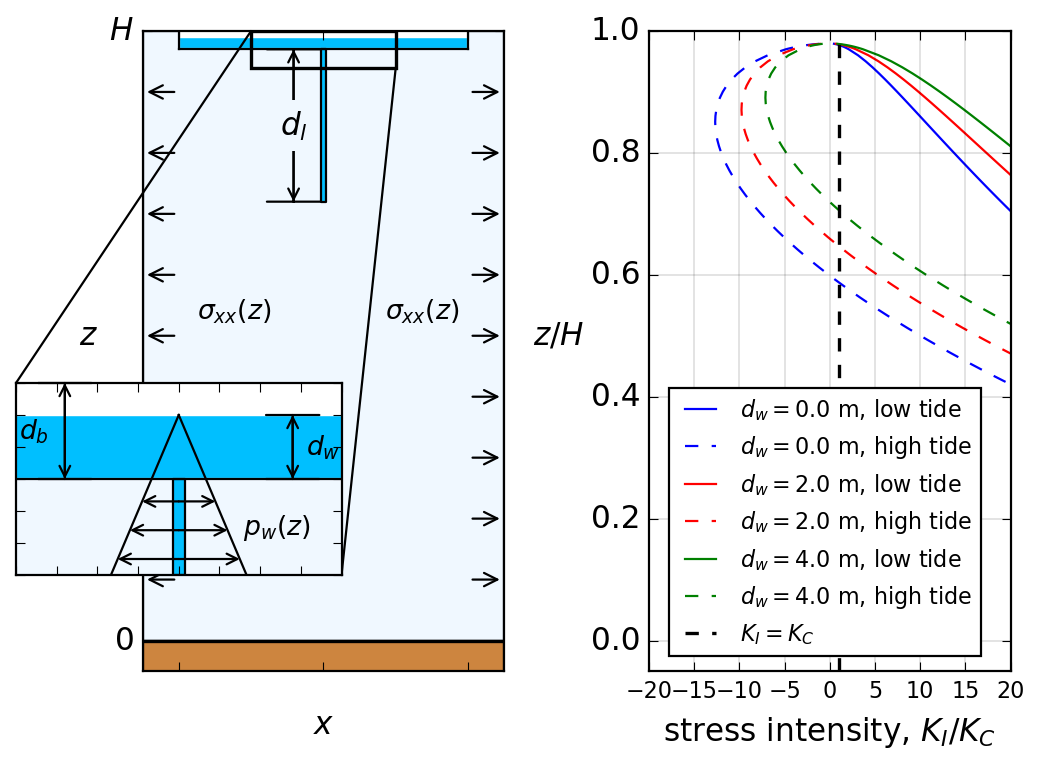

In [17]:
fig,ax = plt.subplots(figsize=(7,5), facecolor='white')
# ------------------------  Panel (a) ------------------------ 
ax = plt.subplot(121)
plt.rcParams["figure.dpi"] = 300
plt.style.use('classic')
plt.rcParams["font.family"] = "dejavusans"
plt.rcParams["mathtext.fontset"] = "dejavusans"
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# stress denotation
for ih,hh in enumerate([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
    arr1 = patches.FancyArrowPatch((Lngth/1e3-2.0,hh*Hght),(Lngth/1e3,hh*Hght), 
                                   arrowstyle='->', mutation_scale=15)
    ax.add_patch(arr1)
    arr1 = patches.FancyArrowPatch((2.0,hh*Hght),(0.0,hh*Hght), 
                                   arrowstyle='->', mutation_scale=15)
    ax.add_patch(arr1)
    
text_t = ax.annotate(r"$\sigma_{xx}\left(z\right)$", xy=(0.15, 0.55),\
                     xycoords='axes fraction',fontsize=fs-2, math_fontfamily='dejavusans')
text_t = ax.annotate(r"$\sigma_{xx}\left(z\right)$", xy=(0.67, 0.55),\
                     xycoords='axes fraction',fontsize=fs-2, math_fontfamily='dejavusans')

# fill-in color
ice_fill = ax.fill_between(np.linspace(0,Lngth,100)/1000,y1=np.zeros(100), y2=Hght*np.ones(100),\
                           facecolor='aliceblue',alpha=1.0) # iceb
bedrock_fill = ax.fill_between(np.linspace(0,Lngth,100)/1000,-13*Hght*np.ones(100),np.zeros(100),\
                               facecolor='peru',alpha=1.0) # bedrock
lake_fill = ax.fill_between([x_left,x_right],[Hght-d_l,Hght-d_l], [Hght-d_l+h_w,Hght-d_l+h_w],\
                            facecolor='deepskyblue',alpha=1.0,edgecolor='white') # ice
lake_fill_2 = ax.fill_between([x_left,x_right],[Hght-d_l+h_w,Hght-d_l+h_w], [Hght+1000,Hght+1000],\
                              facecolor='white',alpha=1.0,edgecolor='white') # ice
crack_fill = ax.fill_between([9.85,10.15],[Hght-d_l-d_f,Hght-d_l-d_f], [Hght-d_l,Hght-d_l],\
                             facecolor='deepskyblue',alpha=1.0) # ice

# lake margins
ax.plot([x_left,x_left],[Hght,Hght-d_l],color='black',linewidth=1.0,label=r'$h$')
ax.plot([x_right,x_right],[Hght,Hght-d_l],color='black',linewidth=1.0,label=r'$h$')
ax.plot([x_left,x_right],[Hght-d_l,Hght-d_l],color='black',linewidth=1.0,label=r'$h$')

# lake depth annotation
deltax = 1.4
ax.annotate("", xy=(9.75-deltax,Hght-d_l), xytext=(9.75-deltax,Hght-d_l-d_f),\
            arrowprops=dict(arrowstyle='<->',shrinkA=0,shrinkB=0))
ax.annotate("", xy=(9.75-deltax,Hght-d_l), xytext=(9.75-deltax,Hght-d_l-d_f),\
            arrowprops=dict(arrowstyle='|-|',shrinkA=0,shrinkB=0))
bbox=dict(fc="aliceblue", ec="none")
text_t = ax.annotate(r"$d_l$", xy=(9.75-deltax,Hght-d_l-0.5*d_f),textcoords=ax.transData,\
                     xycoords='axes fraction',fontsize=fs, ha="center", va="center", bbox=bbox)

# ice-bedrock interface
ax.plot(np.linspace(0,Lngth,100)/1000,np.zeros(100),color='k',linewidth=1.5,label=r'$\beta$')

# y axis
plt.yticks([0,1.0*Hght],\
           [r'$0$',r'$H$'],\
           fontsize=fs, math_fontfamily='dejavusans')
plt.ylabel(r'$z$',fontsize=fs,rotation=0, math_fontfamily='dejavusans')
ax.set_ylim([-0.05*Hght,1.0*Hght])
ax.yaxis.set_label_coords(-0.15, 0.5)

# x axis
plt.xlabel(r'$x$',fontsize=fs,rotation=0, math_fontfamily='dejavusans')
plt.xticks(np.array([x_left,10,x_right]),['-1','0','1'],fontsize=fs, visible=False)
ax.set_xlim([0,Lngth/1e3])
ax.xaxis.set_label_coords(0.5, -0.06)


# ------------------------ Zoom in window ------------------------
x1, x2, y1, y2 = x_left+4, x_right-4, Hght-2.0*d_l, Hght

axins = ax.inset_axes([0.-0.35, 0.15, 0.9, 0.3])
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
ax.indicate_inset_zoom(axins, edgecolor="black",linewidth = 1.5,alpha=1.0)
    
# fill in color
ice_fill = axins.fill_between(np.linspace(0,Lngth,100)/1000,y1=np.zeros(100), y2=Hght*np.ones(100),\
                              facecolor='aliceblue',alpha=1.0) # iceb
bedrock_fill = axins.fill_between(np.linspace(0,Lngth,100)/1000,-13*Hght*np.ones(100),np.zeros(100),\
                                  facecolor='peru',alpha=1.0) # bedrock
lake_fill = axins.fill_between([x_left,x_right],[Hght-d_l,Hght-d_l], [Hght-d_l+h_w,Hght-d_l+h_w],\
                               facecolor='deepskyblue',alpha=1.0,edgecolor='white') # ice
lake_fill_2 = axins.fill_between([x_left,x_right],[Hght-d_l+h_w,Hght-d_l+h_w], [Hght+1000,Hght+1000],\
                                 facecolor='white',alpha=1.0,edgecolor='white') # ice
crack_fill = axins.fill_between([9.85,10.15],[Hght-d_l-d_l,Hght-d_l-d_l], [Hght-d_l,Hght-d_l],\
                                facecolor='deepskyblue',alpha=1.0) # ice
    
# margins
axins.plot([x_left,x_left],[Hght,Hght-d_l],color='black',linewidth=1.0,label=r'$h$')
axins.plot([x_right,x_right],[Hght,Hght-d_l],color='black',linewidth=1.0,label=r'$h$')
axins.plot([x_left,x_right],[Hght-d_l,Hght-d_l],color='black',linewidth=1.0,label=r'$h$')

deltax = 5.2
#  basin depth
axins.annotate("", xy=(x_left+deltax,Hght), xytext=(x_left+deltax,Hght-d_l),\
            arrowprops=dict(arrowstyle='<->',shrinkA=0,shrinkB=0))
axins.annotate("", xy=(x_left+deltax,Hght), xytext=(x_left+deltax,Hght-d_l),\
            arrowprops=dict(arrowstyle='|-|',shrinkA=0,shrinkB=0))
bbox=dict(fc="aliceblue", ec="none")
text_t = axins.annotate(r"$d_b$", xy=(x_left+deltax-.75,Hght-0.5*d_l),textcoords=axins.transData,\
                     xycoords='axes fraction',fontsize=fs-2, ha="center", va="center", bbox=bbox, math_fontfamily='dejavusans')
text_t.set_bbox(dict(alpha=0.0))

#  water depth
axins.annotate("", xy=(x_right-deltax,Hght-d_l+h_w), xytext=(x_right-deltax,Hght-d_l),\
            arrowprops=dict(arrowstyle='<->',shrinkA=0,shrinkB=0))
axins.annotate("", xy=(x_right-deltax,Hght-d_l+h_w), xytext=(x_right-deltax,Hght-d_l),\
            arrowprops=dict(arrowstyle='|-|',shrinkA=0,shrinkB=0))
bbox=dict(fc="aliceblue", ec="none")
text_t = axins.annotate(r"$d_w$", xy=(x_right-deltax+.75,Hght-d_l+0.5*h_w),textcoords=axins.transData,\
                     xycoords='axes fraction',fontsize=fs-2,ha="center", va="center", bbox=bbox, math_fontfamily='dejavusans')
text_t.set_bbox(dict(alpha=0.0))


# water pressure annotations
for ih,hh in enumerate(np.arange(0.9,2.,0.3)):
    axins.annotate("", xy=((0.5+hh*0.05)*Lngth/1e3,Hght-hh*d_l-d_l+h_w), xytext=(0.5*Lngth/1e3,Hght-hh*d_l-d_l+h_w),\
            arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))
    axins.annotate("", xy=((0.5-hh*0.05)*Lngth/1e3,Hght-hh*d_l-d_l+h_w), xytext=(0.5*Lngth/1e3,Hght-hh*d_l-d_l+h_w),\
            arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0))
    
xx = [(0.5)*Lngth/1e3,(0.5+1.8*0.05)*Lngth/1e3]
xx1 = [(0.5)*Lngth/1e3,(0.5-1.8*0.05)*Lngth/1e3]
yy = [Hght-d_l+h_w,Hght-d_l+h_w-1.8*d_l]
axins.plot(xx,yy,color='black',linewidth=1.0)
axins.plot(xx1,yy,color='black',linewidth=1.0)
text_t = axins.annotate(r"$p_w(z)$", xy=(0.62*Lngth/1e3,Hght-1.5*d_l),textcoords=axins.transData,\
                        xycoords='axes fraction',fontsize=fs-2, ha="center", va="center", math_fontfamily='dejavusans')

# ------------------------ Panel (b) ------------------------
ax = plt.subplot(122)
book = np.arange(0,10,4, dtype=int) 
color = ['blue','red','green']
for count,i in enumerate(book):
    ax.plot(vK1_max[i,:]/KIc,(500-depth_basin-vZc_max)/500,color=color[count],label=r'$d_w='+str(v_dl[i])+'~$m, low tide')
    ax.plot(vK1_min[i,:]/KIc,(500-depth_basin-vZc_min)/500,linestyle='--',color=color[count],label=r'$d_w='+str(v_dl[i])+'~$m, high tide')

ax.set_ylim([-0.05,1.0])
plt.yticks(fontsize=fs)
ax.set_ylabel(r'$z/H$',fontsize=fs, rotation=0, color='k', math_fontfamily='dejavusans')
ax.yaxis.set_label_coords(-0.25, 0.50)

plt.xticks(fontsize=fs-4)
ax.set_xlim([-20,20])
ax.set_xlabel(r'stress intensity, $K_{I}/K_{C}$',fontsize=fs, rotation=0, color='k', math_fontfamily='dejavusans')

ax.axvline(x=1,ymax=5e2,linestyle='--',color='k',linewidth=1.5,label=r'$K_{I}=K_{C}$')

lgd = ax.legend(scatterpoints=1,fontsize=fs-4,bbox_to_anchor=(0.95, 0.46),ncol=1)
ax.grid(True, linewidth=0.1, linestyle='-')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.0)
plt.savefig('./figures/figure_4.tiff',bbox_inches='tight',dpi=600)